In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
data = pd.read_csv("../data/nhgh.tsv", sep = "\t")

### Data Preprocessing

In [5]:
# Convert factors into One Hot Encoding
data = pd.get_dummies(data, columns=["sex", "re", "income"], drop_first=True)

# Separate predictors and responses
x = data.drop("gh", axis=1)
y = data["gh"].map(lambda x: 1 if x >= 6.5 else 0)

# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=999)

##### Data Imputation

There are lots of missing values in the dataset, and to cope with this, we simply use the training dataset to fill the values for both the training and test dataset. I do not utilize the test dataset for imputation at all in order to respect its secrecy, as the training process must not look at the test dataset.

For the numeric columns, it is very straightforward, as we can simply take the mean of the training data's respective column. On the contrary, for the factor columns (income), we need to do some extra steps. From the bar graph below, we can clearly see that taking the mode of the column won't suffice, as the distribution of the income is quite varied. Thus, setting 1 level for all the missing values will be not be an option.

<Axes: xlabel='income'>

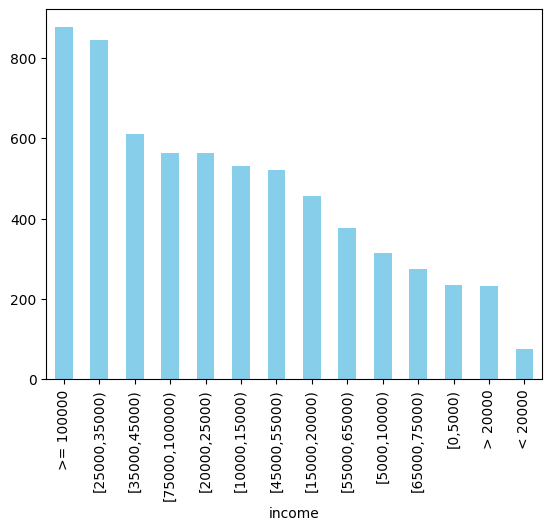

In [4]:

# Count the occurrences of each string
counts = data["income"].value_counts()
counts.plot(kind='bar', color='skyblue')


In [ ]:
# Impute missing data using training data mean
x_train.fillna(x_train.mean())
x_test.fillna(x_train.mean())
x_train.mean()

In [26]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values